# Workshop 10 - Generative AI
1. Variational Autoencoder
2. Simple Diffusion Model
3. Train Diffusion Model with `denoising_diffusion_pytorch`
4. Generate Images using `diffusers` Stable Diffusion Pre-trained model

# Variational Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

In [2]:
# Define the encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        

    def forward(self, x):
        x = torch.relu(self.fc(x))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var 
        

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        output = torch.sigmoid(self.fc2(h))
        return output
        

# Define the VAE by combining the encoder and decoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x) 
        z = self.reparameterize(mu, log_var)
        output = self.decoder(z)
        return output, mu, log_var
        

In [3]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # Binary Cross-Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Kullback-Leibler Divergence 
    return BCE + KLD

# Training function
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(-1, input_dim) # 32 x 1 x 28 x 28 --> 32 x n
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}')


In [4]:
# Hyperparameters
input_dim = 28 * 28  # For MNIST dataset
hidden_dim = 400
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
epochs = 10

In [5]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, and training loop
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)

Epoch: 1 [0/60000 (0%)]	Loss: 548.208618
Epoch: 1 [12800/60000 (21%)]	Loss: 177.378998
Epoch: 1 [25600/60000 (43%)]	Loss: 154.227127
Epoch: 1 [38400/60000 (64%)]	Loss: 142.647156
Epoch: 1 [51200/60000 (85%)]	Loss: 130.136505
====> Epoch: 1 Average loss: 163.3375
Epoch: 2 [0/60000 (0%)]	Loss: 130.292770
Epoch: 2 [12800/60000 (21%)]	Loss: 127.329651
Epoch: 2 [25600/60000 (43%)]	Loss: 123.514404
Epoch: 2 [38400/60000 (64%)]	Loss: 117.653564
Epoch: 2 [51200/60000 (85%)]	Loss: 115.944290
====> Epoch: 2 Average loss: 121.4684
Epoch: 3 [0/60000 (0%)]	Loss: 118.584534
Epoch: 3 [12800/60000 (21%)]	Loss: 112.835800
Epoch: 3 [25600/60000 (43%)]	Loss: 112.043259
Epoch: 3 [38400/60000 (64%)]	Loss: 117.347687
Epoch: 3 [51200/60000 (85%)]	Loss: 116.018219
====> Epoch: 3 Average loss: 114.3667
Epoch: 4 [0/60000 (0%)]	Loss: 111.637787
Epoch: 4 [12800/60000 (21%)]	Loss: 115.172218
Epoch: 4 [25600/60000 (43%)]	Loss: 108.455719
Epoch: 4 [38400/60000 (64%)]	Loss: 114.153938
Epoch: 4 [51200/60000 (85%)]	Los

In [7]:
# Generate some images
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = model.decoder(z).view(-1, 1, 28, 28)

# Save or visualize the generated images
torchvision.utils.save_image(sample, 'generated_MNIST.png')

# Train Simple Diffusion Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Define parameters
num_timesteps = 1000
batch_size = 32
betas = torch.linspace(0.0001, 0.02, num_timesteps).to(device)  # Linear schedule


# Loss function: Mean Squared Error for noise prediction
loss_fn = nn.MSELoss()

# Load the dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/home/ubuntu/data/projects/csc6203/cats', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Timestep Embedding
        self.time_embed = nn.Embedding(num_embeddings=num_timesteps, embedding_dim=256)
        
        # Define a simple UNet-like structure or another network architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        

    def forward(self, x, t):
        # Encode
        h = self.encoder(x)

        # Process the timestep t
        t = t.unsqueeze(-1)  # Convert to shape (batch_size, 1)
        t_emb = self.time_embed(t) # batch_size x 1 x 256
        t_emb = t_emb.view(t_emb.size(0),t_emb.size(-1), 1, 1) # batch_size x 256 x 1 x 1
        t_emb = t_emb.expand_as(h)  # Expand to match the shape of the feature map
        
        # # Add the timestep embedding to the encoded features
        h = h + t_emb

        # Decode
        output = self.decoder(h)
        return output
        
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Forward Process : 
$x_t = \sqrt{1-\beta_t} . x_{t-1} + \sqrt{\beta_t} . \epsilon_t $

Reverse Process : 
$x_{t-1} = {x_t-\sqrt{\beta_t}.\epsilon_t}/{\sqrt{1-\beta_t}}$

In [12]:
# Forward process: q(x_t | x_{t-1})
def q_sample(x_start, t, noise):
    x_t = x_start * torch.sqrt(1 - betas[t]).view(x_start.size(0),1,1,1) + noise * torch.sqrt(betas[t]).view(x_start.size(0),1,1,1)
    return x_t
    
# Reverse process: p_theta(x_{t-1} | x_t)
def p_sample(model, x_t, t):
    predicted_noise = model(x_t, t)
    return (x_t - predicted_noise * torch.sqrt(betas[t]))/torch.sqrt(1-betas[t])


In [18]:
# Training loop
for epoch in range(15):  # Number of epochs
    for batch in dataloader:
        x_start = batch[0].to(device)
        t = torch.randint(0, num_timesteps, (x_start.size(0),), device=device).long()

        noise = torch.randn_like(x_start)
        x_t = q_sample(x_start, t, noise)

        optimizer.zero_grad()

        noise_pred = model(x_t, t)

        loss = loss_fn(noise_pred, noise)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}: Loss = {loss.item()}')

Epoch 0: Loss = 1.0374960899353027
Epoch 1: Loss = 1.014533519744873
Epoch 2: Loss = 0.9832549095153809
Epoch 3: Loss = 0.99582839012146
Epoch 4: Loss = 1.0127842426300049
Epoch 5: Loss = 0.9712004065513611
Epoch 6: Loss = 0.9900126457214355
Epoch 7: Loss = 1.0322294235229492
Epoch 8: Loss = 0.9961490035057068
Epoch 9: Loss = 0.9913361668586731
Epoch 10: Loss = 1.0231081247329712
Epoch 11: Loss = 1.0032858848571777
Epoch 12: Loss = 1.023219108581543
Epoch 13: Loss = 0.998001217842102
Epoch 14: Loss = 1.0213427543640137


In [19]:
@torch.no_grad()
def sample_image(model, num_samples=64):
    model.eval()
    x = torch.randn(num_samples, 1, 64, 64).to(device)
    
    for t in torch.range(num_timesteps-1, 0, -1).long().to(device):
        x = p_sample(model, x, t)
    return x

sampled_images = sample_image(model)
save_image(sampled_images, 'generated_cats.png', nrow=8)

/tmp/ipykernel_1363133/198888943.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for t in torch.range(num_timesteps-1, 0, -1).long().to(device):


# Using `denoising-diffusion-pytorch` library
Git Hub : https://github.com/lucidrains/denoising-diffusion-pytorch/tree/main

In [ ]:
pip install denoising_diffusion_pytorch

In [20]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import matplotlib.pyplot as plt

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
)

diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 10,           # number of steps
    sampling_timesteps = 8    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    '/home/ubuntu/data/projects/csc6203/cats/Cat',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 20,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)

trainer.train()

/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

training complete


In [21]:
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step:   0%|          | 0/8 [00:00<?, ?it/s]

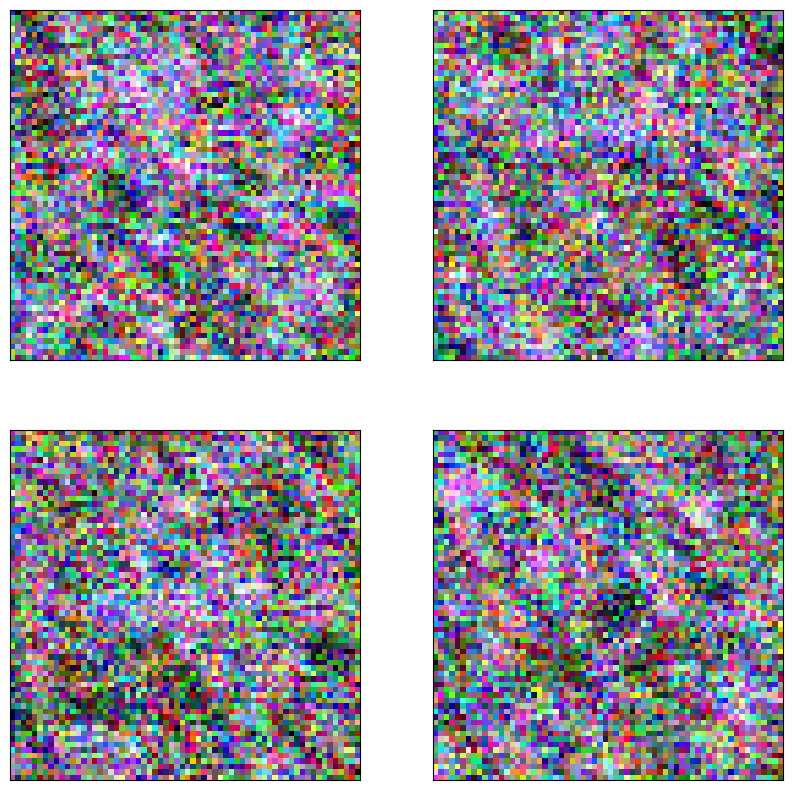

In [22]:
tensor = sampled_images.cpu().permute(0, 2, 3, 1)

# Create a figure with 4 subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the subplots and the tensor
for i, ax in enumerate(axs.flat):
    # Display the image on the current subplot
    ax.imshow(tensor[i])
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the plot
plt.show()

# Use pre-trained diffusion models
https://huggingface.co/docs/diffusers/en/index

In [ ]:
pip install diffusers

In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [24]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Load pre-trained model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True, cache_dir="/home/ubuntu/data/.cache")
pipe.to(device)

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

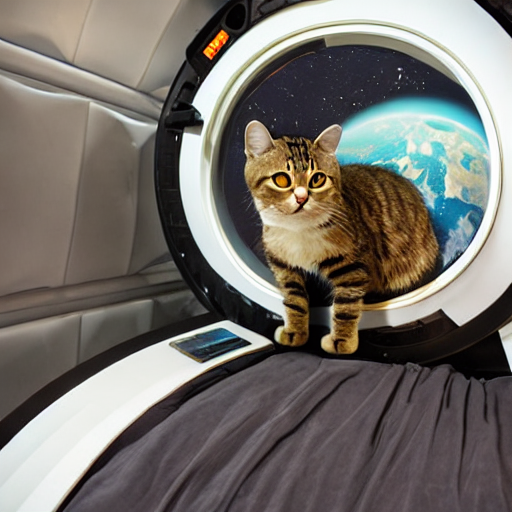

In [28]:
# Define prompt and generate image
prompt = "cat on a spacesuite"
image = pipe(prompt).images[0]

# Display generated image
image.show()